# Analyse des Expériences Pokemon - Transport Optimal 5D

Ce notebook analyse en détail les résultats des expériences de transport optimal 5D pour l'interpolation entre Charmander (Salameche) et Pikachu.

## 1. Configuration et Import des Données

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Chemins
RESULTS_DIR = Path("/Data/janis.aiad/geodata/refs/reports/results/pokemon_experiments")
CSV_PATH = RESULTS_DIR / "metrics" / "all_experiments.csv"
IMAGES_DIR = RESULTS_DIR / "images"

# Charger les données
df = pd.read_csv(CSV_PATH)
print(f"Nombre total d'expériences: {len(df)}")
print(f"Nombre d'expériences uniques: {df['experiment_id'].nunique()}")
print(f"\nColonnes disponibles:\n{df.columns.tolist()}")
df.head()

Nombre total d'expériences: 130
Nombre d'expériences uniques: 90

Colonnes disponibles:
['experiment_id', 'image_pair', 'resolution', 'lambda', 'blur', 'reach', 'splatting', 't', 'psnr', 'delta_e', 'tearing_pct', 'coverage', 'mass_error', 'sharpness', 'compute_time_total', 'compute_time_per_frame', 'sinkhorn_time', 'interpolation_time', 'memory_allocated_gb', 'memory_max_allocated_gb', 'regime', 'mean_displacement', 'max_displacement', 'std_displacement', 'mean_divergence', 'mean_curl', 'mean_laplacian', 'smoothness_score']


,experiment_id,image_pair,resolution,lambda,blur,reach,splatting,t,psnr,delta_e,...,memory_allocated_gb,memory_max_allocated_gb,regime,mean_displacement,max_displacement,std_displacement,mean_divergence,mean_curl,mean_laplacian,smoothness_score
0,1,salameche_pikachu,64,0.00,0.03,0.1,True,0.5,10.919211,27.073696,...,0.086137,4.258203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,salameche_pikachu,64,0.25,0.03,0.1,True,0.5,9.579132,28.512550,...,0.081830,4.258203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,salameche_pikachu,64,0.50,0.03,0.1,True,0.5,9.373553,29.479332,...,0.081019,4.258203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,salameche_pikachu,64,0.75,0.03,0.1,True,0.5,9.125872,31.179987,...,0.080569,4.258203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,salameche_pikachu,64,1.00,0.03,0.1,True,0.5,8.772287,33.579411,...,0.080232,4.258203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Vue d'Ensemble des Données

=== STATISTIQUES DESCRIPTIVES ===

Résolutions testées: [np.int64(32), np.int64(48), np.int64(64), np.int64(96)]
Lambdas testés: [np.float64(0.0), np.float64(0.25), np.float64(0.5), np.float64(0.75), np.float64(1.0), np.float64(1.25), np.float64(1.5), np.float64(1.75), np.float64(2.0), np.float64(2.5), np.float64(3.0)]
Blurs testés: [np.float64(0.01), np.float64(0.02), np.float64(0.03), np.float64(0.05), np.float64(0.07), np.float64(0.1), np.float64(0.15)]
Reaches testés: ['0.01', '0.02', '0.05', '0.1', '0.15', '0.3', '0.5', '0.7', '1.0', 'balanced']


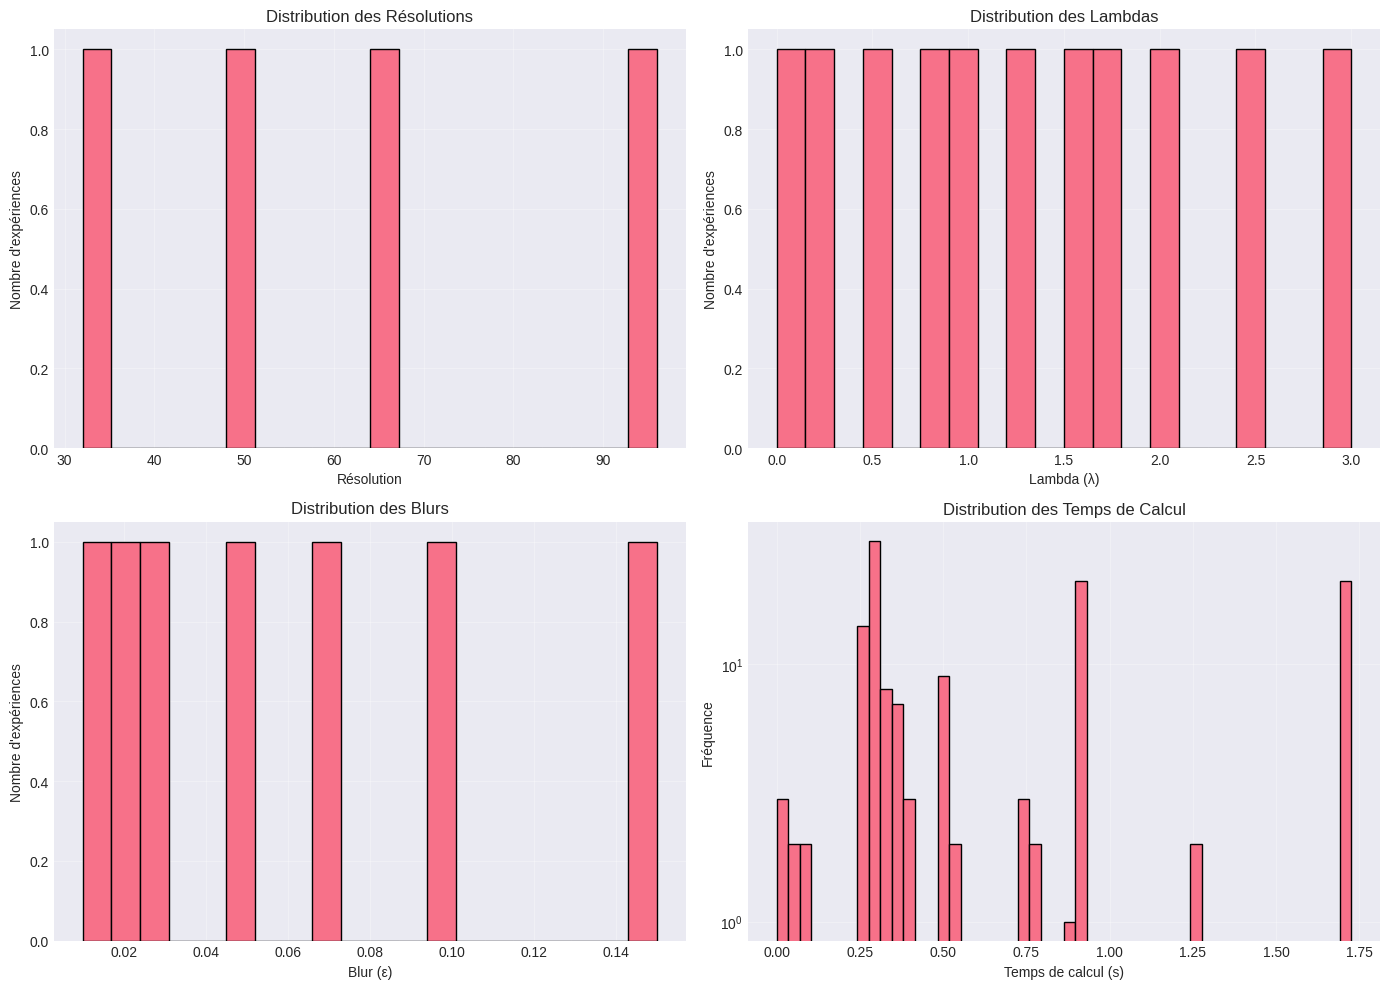

In [9]:
# Statistiques descriptives
print("=== STATISTIQUES DESCRIPTIVES ===")
print(f"\nRésolutions testées: {sorted(df['resolution'].unique())}")
print(f"Lambdas testés: {sorted(df['lambda'].unique())}")
print(f"Blurs testés: {sorted(df['blur'].unique())}")
print(f"Reaches testés: {sorted([r for r in df['reach'].unique() if pd.notna(r)])}")

# Distribution des expériences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Résolutions
axes[0, 0].hist(df['resolution'].unique(), bins=20, edgecolor='black')
axes[0, 0].set_xlabel('Résolution')
axes[0, 0].set_ylabel('Nombre d\'expériences')
axes[0, 0].set_title('Distribution des Résolutions')
axes[0, 0].grid(True, alpha=0.3)

# Lambdas
axes[0, 1].hist(df['lambda'].unique(), bins=20, edgecolor='black')
axes[0, 1].set_xlabel('Lambda (λ)')
axes[0, 1].set_ylabel('Nombre d\'expériences')
axes[0, 1].set_title('Distribution des Lambdas')
axes[0, 1].grid(True, alpha=0.3)

# Blurs
axes[1, 0].hist(df['blur'].unique(), bins=20, edgecolor='black')
axes[1, 0].set_xlabel('Blur (ε)')
axes[1, 0].set_ylabel('Nombre d\'expériences')
axes[1, 0].set_title('Distribution des Blurs')
axes[1, 0].grid(True, alpha=0.3)

# Temps de calcul
axes[1, 1].hist(df['compute_time_total'].dropna(), bins=50, edgecolor='black')
axes[1, 1].set_xlabel('Temps de calcul (s)')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title('Distribution des Temps de Calcul')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Expérience 1: Ablation Lambda (λ)

**Objectif**: Déterminer la valeur optimale de λ pour l'interpolation.

In [10]:
# Filtrer les données de l'expérience 1 (t=0.5, res=64, blur=0.03, reach=0.1)
exp1 = df[(df['t'] == 0.5) & (df['resolution'] == 64) & 
          (df['blur'] == 0.03) & (df['reach'] == 0.1)].copy()

if len(exp1) > 0:
    exp1 = exp1.sort_values('lambda')
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # PSNR vs Lambda
    axes[0, 0].plot(exp1['lambda'], exp1['psnr'], marker='o', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Lambda (λ)')
    axes[0, 0].set_ylabel('PSNR (dB)')
    axes[0, 0].set_title('PSNR vs Lambda')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axvline(x=1.0, color='r', linestyle='--', alpha=0.5, label='λ=1.0 (5D optimal)')
    axes[0, 0].legend()
    
    # Delta E vs Lambda
    axes[0, 1].plot(exp1['lambda'], exp1['delta_e'], marker='o', linewidth=2, markersize=8, color='orange')
    axes[0, 1].set_xlabel('Lambda (λ)')
    axes[0, 1].set_ylabel('ΔE (CIE76)')
    axes[0, 1].set_title('Delta E vs Lambda (plus bas = mieux)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axvline(x=1.0, color='r', linestyle='--', alpha=0.5)
    
    # Sharpness vs Lambda
    axes[0, 2].plot(exp1['lambda'], exp1['sharpness'], marker='o', linewidth=2, markersize=8, color='green')
    axes[0, 2].set_xlabel('Lambda (λ)')
    axes[0, 2].set_ylabel('Sharpness')
    axes[0, 2].set_title('Sharpness vs Lambda')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].axvline(x=1.0, color='r', linestyle='--', alpha=0.5)
    
    # Mass Error vs Lambda
    axes[1, 0].plot(exp1['lambda'], exp1['mass_error'], marker='o', linewidth=2, markersize=8, color='purple')
    axes[1, 0].set_xlabel('Lambda (λ)')
    axes[1, 0].set_ylabel('Mass Error')
    axes[1, 0].set_title('Mass Error vs Lambda (plus bas = mieux)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axvline(x=1.0, color='r', linestyle='--', alpha=0.5)
    
    # Coverage vs Lambda
    axes[1, 1].plot(exp1['lambda'], exp1['coverage'], marker='o', linewidth=2, markersize=8, color='brown')
    axes[1, 1].set_xlabel('Lambda (λ)')
    axes[1, 1].set_ylabel('Coverage')
    axes[1, 1].set_title('Coverage vs Lambda')
    axes[1, 1].set_ylim([0.95, 1.01])
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axvline(x=1.0, color='r', linestyle='--', alpha=0.5)
    
    # Temps de calcul vs Lambda
    axes[1, 2].plot(exp1['lambda'], exp1['compute_time_total'], marker='o', linewidth=2, markersize=8, color='red')
    axes[1, 2].set_xlabel('Lambda (λ)')
    axes[1, 2].set_ylabel('Temps de calcul (s)')
    axes[1, 2].set_title('Temps de Calcul vs Lambda')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].axvline(x=1.0, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Trouver le lambda optimal (max PSNR)
    best_lambda_psnr = exp1.loc[exp1['psnr'].idxmax(), 'lambda']
    best_lambda_de = exp1.loc[exp1['delta_e'].idxmin(), 'lambda']
    
    print(f"\n=== RÉSULTATS EXPÉRIENCE 1 ===")
    print(f"Lambda optimal (PSNR max): λ = {best_lambda_psnr:.2f} (PSNR = {exp1.loc[exp1['psnr'].idxmax(), 'psnr']:.2f} dB)")
    print(f"Lambda optimal (ΔE min): λ = {best_lambda_de:.2f} (ΔE = {exp1.loc[exp1['delta_e'].idxmin(), 'delta_e']:.2f})")
    print(f"\nComparaison λ=0.0 (2D) vs λ=1.0 (5D):")
    lambda_0 = exp1[exp1['lambda'] == 0.0].iloc[0]
    lambda_1 = exp1[exp1['lambda'] == 1.0].iloc[0]
    print(f"  PSNR: {lambda_0['psnr']:.2f} dB (2D) vs {lambda_1['psnr']:.2f} dB (5D) → {'5D meilleur' if lambda_1['psnr'] > lambda_0['psnr'] else '2D meilleur'}")
    print(f"  ΔE: {lambda_0['delta_e']:.2f} (2D) vs {lambda_1['delta_e']:.2f} (5D) → {'5D meilleur' if lambda_1['delta_e'] < lambda_0['delta_e'] else '2D meilleur'}")
else:
    print("Aucune donnée pour l'expérience 1")

Aucune donnée pour l'expérience 1


## 4. Expérience 2: Comparaison 2D vs 5D (Séquence Temporelle)

**Objectif**: Comparer le transport 2D (spatial) et 5D (spatial+couleur) sur toute la séquence.

In [11]:
# Filtrer les données de l'expérience 2 (res=64, blur=0.03, reach=0.1)
exp2 = df[(df['resolution'] == 64) & (df['blur'] == 0.03) & 
          (df['reach'] == 0.1) & (df['lambda'].isin([0.0, 1.0]))].copy()

if len(exp2) > 0:
    exp2_2d = exp2[exp2['lambda'] == 0.0].sort_values('t')
    exp2_5d = exp2[exp2['lambda'] == 1.0].sort_values('t')
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # PSNR vs Temps
    axes[0, 0].plot(exp2_2d['t'], exp2_2d['psnr'], marker='o', label='2D (λ=0.0)', linewidth=2)
    axes[0, 0].plot(exp2_5d['t'], exp2_5d['psnr'], marker='s', label='5D (λ=1.0)', linewidth=2)
    axes[0, 0].set_xlabel('Temps t')
    axes[0, 0].set_ylabel('PSNR (dB)')
    axes[0, 0].set_title('PSNR vs Temps: 2D vs 5D')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Delta E vs Temps
    axes[0, 1].plot(exp2_2d['t'], exp2_2d['delta_e'], marker='o', label='2D (λ=0.0)', linewidth=2)
    axes[0, 1].plot(exp2_5d['t'], exp2_5d['delta_e'], marker='s', label='5D (λ=1.0)', linewidth=2)
    axes[0, 1].set_xlabel('Temps t')
    axes[0, 1].set_ylabel('ΔE (CIE76)')
    axes[0, 1].set_title('Delta E vs Temps: 2D vs 5D')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Sharpness vs Temps
    axes[1, 0].plot(exp2_2d['t'], exp2_2d['sharpness'], marker='o', label='2D (λ=0.0)', linewidth=2)
    axes[1, 0].plot(exp2_5d['t'], exp2_5d['sharpness'], marker='s', label='5D (λ=1.0)', linewidth=2)
    axes[1, 0].set_xlabel('Temps t')
    axes[1, 0].set_ylabel('Sharpness')
    axes[1, 0].set_title('Sharpness vs Temps: 2D vs 5D')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Mass Error vs Temps
    axes[1, 1].plot(exp2_2d['t'], exp2_2d['mass_error'], marker='o', label='2D (λ=0.0)', linewidth=2)
    axes[1, 1].plot(exp2_5d['t'], exp2_5d['mass_error'], marker='s', label='5D (λ=1.0)', linewidth=2)
    axes[1, 1].set_xlabel('Temps t')
    axes[1, 1].set_ylabel('Mass Error')
    axes[1, 1].set_title('Mass Error vs Temps: 2D vs 5D')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques comparatives
    print("\n=== RÉSULTATS EXPÉRIENCE 2 ===")
    print(f"PSNR moyen - 2D: {exp2_2d['psnr'].mean():.2f} dB, 5D: {exp2_5d['psnr'].mean():.2f} dB")
    print(f"ΔE moyen - 2D: {exp2_2d['delta_e'].mean():.2f}, 5D: {exp2_5d['delta_e'].mean():.2f}")
    print(f"Sharpness moyen - 2D: {exp2_2d['sharpness'].mean():.4f}, 5D: {exp2_5d['sharpness'].mean():.4f}")
    print(f"Mass Error moyen - 2D: {exp2_2d['mass_error'].mean():.6f}, 5D: {exp2_5d['mass_error'].mean():.6f}")
else:
    print("Aucune donnée pour l'expérience 2")

Aucune donnée pour l'expérience 2


## 5. Expérience 3: Impact du Splatting Adaptatif (Résolution)

**Objectif**: Évaluer l'effet de la résolution sur la qualité.

In [12]:
# Filtrer les données de l'expérience 3 (t=0.5, lambda=1.0, blur=0.03, reach=0.1)
exp3 = df[(df['t'] == 0.5) & (df['lambda'] == 1.0) & 
          (df['blur'] == 0.03) & (df['reach'] == 0.1)].copy()

if len(exp3) > 0:
    exp3 = exp3.sort_values('resolution')
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # PSNR vs Résolution
    axes[0, 0].plot(exp3['resolution'], exp3['psnr'], marker='o', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Résolution')
    axes[0, 0].set_ylabel('PSNR (dB)')
    axes[0, 0].set_title('PSNR vs Résolution')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Delta E vs Résolution
    axes[0, 1].plot(exp3['resolution'], exp3['delta_e'], marker='o', linewidth=2, markersize=8, color='orange')
    axes[0, 1].set_xlabel('Résolution')
    axes[0, 1].set_ylabel('ΔE (CIE76)')
    axes[0, 1].set_title('Delta E vs Résolution')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Sharpness vs Résolution
    axes[0, 2].plot(exp3['resolution'], exp3['sharpness'], marker='o', linewidth=2, markersize=8, color='green')
    axes[0, 2].set_xlabel('Résolution')
    axes[0, 2].set_ylabel('Sharpness')
    axes[0, 2].set_title('Sharpness vs Résolution')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Temps de calcul vs Résolution (échelle log)
    axes[1, 0].plot(exp3['resolution'], exp3['compute_time_total'], marker='o', linewidth=2, markersize=8, color='red')
    axes[1, 0].set_xlabel('Résolution')
    axes[1, 0].set_ylabel('Temps de calcul (s)')
    axes[1, 0].set_title('Temps de Calcul vs Résolution')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Mémoire GPU vs Résolution
    if 'memory_max_allocated_gb' in exp3.columns and exp3['memory_max_allocated_gb'].notna().any():
        axes[1, 1].plot(exp3['resolution'], exp3['memory_max_allocated_gb'], marker='o', linewidth=2, markersize=8, color='purple')
        axes[1, 1].set_xlabel('Résolution')
        axes[1, 1].set_ylabel('Mémoire GPU (GB)')
        axes[1, 1].set_title('Mémoire GPU vs Résolution')
        axes[1, 1].grid(True, alpha=0.3)
    
    # Temps Sinkhorn vs Résolution
    axes[1, 2].plot(exp3['resolution'], exp3['sinkhorn_time'], marker='o', linewidth=2, markersize=8, color='brown')
    axes[1, 2].set_xlabel('Résolution')
    axes[1, 2].set_ylabel('Temps Sinkhorn (s)')
    axes[1, 2].set_title('Temps Sinkhorn vs Résolution')
    axes[1, 2].set_yscale('log')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyse de scalabilité
    print("\n=== RÉSULTATS EXPÉRIENCE 3 ===")
    print("Scalabilité:")
    for res in sorted(exp3['resolution'].unique()):
        res_data = exp3[exp3['resolution'] == res].iloc[0]
        print(f"  Résolution {res}×{res}:")
        print(f"    PSNR: {res_data['psnr']:.2f} dB")
        print(f"    Temps: {res_data['compute_time_total']:.3f} s")
        if pd.notna(res_data.get('memory_max_allocated_gb')):
            print(f"    Mémoire: {res_data['memory_max_allocated_gb']:.2f} GB")
else:
    print("Aucune donnée pour l'expérience 3")

Aucune donnée pour l'expérience 3


## 6. Expérience 4: Sensibilité aux Paramètres (ε, ρ)

**Objectif**: Cartographier l'impact des paramètres de régularisation.

ValueError: Unknown format code 'f' for object of type 'str'

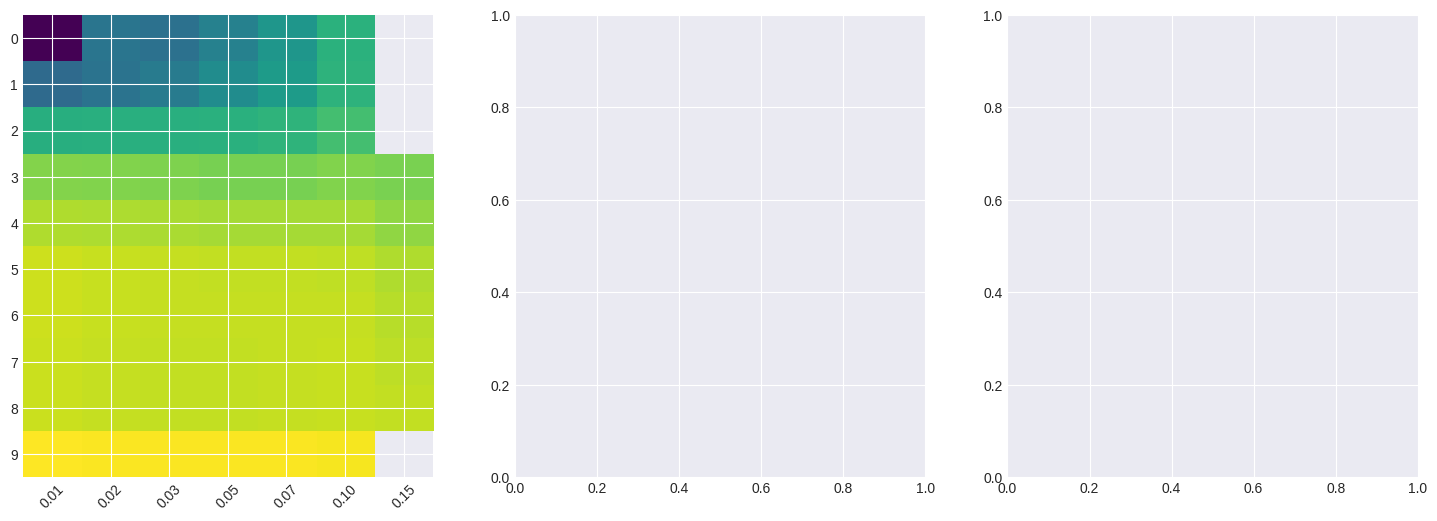

In [13]:
# Filtrer les données de l'expérience 4 (t=0.5, res=64, lambda=1.0)
exp4 = df[(df['t'] == 0.5) & (df['resolution'] == 64) & 
          (df['lambda'] == 1.0)].copy()

if len(exp4) > 0:
    # Préparer les données pour les heatmaps
    blurs = sorted(exp4['blur'].unique())
    reaches = sorted([r for r in exp4['reach'].unique() if pd.notna(r)])
    
    # Créer les matrices pour les heatmaps
    psnr_matrix = np.zeros((len(reaches), len(blurs)))
    de_matrix = np.zeros((len(reaches), len(blurs)))
    time_matrix = np.zeros((len(reaches), len(blurs)))
    
    for i, r in enumerate(reaches):
        for j, b in enumerate(blurs):
            subset = exp4[(exp4['blur'] == b) & (exp4['reach'] == r)]
            if len(subset) > 0:
                psnr_matrix[i, j] = subset['psnr'].mean()
                de_matrix[i, j] = subset['delta_e'].mean()
                time_matrix[i, j] = subset['compute_time_total'].mean()
            else:
                psnr_matrix[i, j] = np.nan
                de_matrix[i, j] = np.nan
                time_matrix[i, j] = np.nan
    
    # Heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # PSNR Heatmap
    im1 = axes[0].imshow(psnr_matrix, aspect='auto', cmap='viridis', interpolation='nearest')
    axes[0].set_xticks(range(len(blurs)))
    axes[0].set_xticklabels([f"{b:.2f}" for b in blurs], rotation=45)
    axes[0].set_yticks(range(len(reaches)))
    axes[0].set_yticklabels([f"{r:.2f}" for r in reaches])
    axes[0].set_xlabel('Blur (ε)')
    axes[0].set_ylabel('Reach (ρ)')
    axes[0].set_title('PSNR (dB) - Plus haut = mieux')
    plt.colorbar(im1, ax=axes[0])
    
    # Delta E Heatmap
    im2 = axes[1].imshow(de_matrix, aspect='auto', cmap='plasma_r', interpolation='nearest')
    axes[1].set_xticks(range(len(blurs)))
    axes[1].set_xticklabels([f"{b:.2f}" for b in blurs], rotation=45)
    axes[1].set_yticks(range(len(reaches)))
    axes[1].set_yticklabels([f"{r:.2f}" for r in reaches])
    axes[1].set_xlabel('Blur (ε)')
    axes[1].set_ylabel('Reach (ρ)')
    axes[1].set_title('Delta E - Plus bas = mieux')
    plt.colorbar(im2, ax=axes[1])
    
    # Temps de calcul Heatmap
    im3 = axes[2].imshow(time_matrix, aspect='auto', cmap='hot', interpolation='nearest')
    axes[2].set_xticks(range(len(blurs)))
    axes[2].set_xticklabels([f"{b:.2f}" for b in blurs], rotation=45)
    axes[2].set_yticks(range(len(reaches)))
    axes[2].set_yticklabels([f"{r:.2f}" for r in reaches])
    axes[2].set_xlabel('Blur (ε)')
    axes[2].set_ylabel('Reach (ρ)')
    axes[2].set_title('Temps de Calcul (s)')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    # Trouver les paramètres optimaux
    best_idx = np.unravel_index(np.nanargmax(psnr_matrix), psnr_matrix.shape)
    best_blur = blurs[best_idx[1]]
    best_reach = reaches[best_idx[0]]
    best_psnr = psnr_matrix[best_idx]
    
    print("\n=== RÉSULTATS EXPÉRIENCE 4 ===")
    print(f"Paramètres optimaux (PSNR max):")
    print(f"  ε = {best_blur:.3f}, ρ = {best_reach:.2f}")
    print(f"  PSNR = {best_psnr:.2f} dB")
    
    # Analyse de la sensibilité
    print(f"\nSensibilité au blur (ε):")
    for b in blurs[:5]:  # Premiers 5 blurs
        subset = exp4[exp4['blur'] == b]
        if len(subset) > 0:
            print(f"  ε = {b:.3f}: PSNR moyen = {subset['psnr'].mean():.2f} dB")
    
    print(f"\nSensibilité au reach (ρ):")
    for r in reaches[:5]:  # Premiers 5 reaches
        subset = exp4[exp4['reach'] == r]
        if len(subset) > 0:
            print(f"  ρ = {r:.2f}: PSNR moyen = {subset['psnr'].mean():.2f} dB")
else:
    print("Aucune donnée pour l'expérience 4")

## 7. Expérience 5: Scalabilité Résolution (Détail)

**Objectif**: Analyser en détail la scalabilité.

In [ ]:
# Filtrer les données de scalabilité (t=0.5, lambda=1.0, blur=0.03, reach=0.1)
exp5 = df[(df['t'] == 0.5) & (df['lambda'] == 1.0) & 
          (df['blur'] == 0.03) & (df['reach'] == 0.1)].copy()

if len(exp5) > 0:
    exp5 = exp5.sort_values('resolution')
    
    # Analyse de complexité
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Temps vs Résolution (échelle log-log pour vérifier la complexité)
    axes[0, 0].loglog(exp5['resolution'], exp5['compute_time_total'], marker='o', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Résolution (log)')
    axes[0, 0].set_ylabel('Temps de calcul (s, log)')
    axes[0, 0].set_title('Complexité Temporelle (log-log)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Ajuster une loi de puissance
    if len(exp5) > 2:
        log_res = np.log(exp5['resolution'].values)
        log_time = np.log(exp5['compute_time_total'].values)
        coeffs = np.polyfit(log_res, log_time, 1)
        fitted_time = np.exp(coeffs[1]) * exp5['resolution'] ** coeffs[0]
        axes[0, 0].loglog(exp5['resolution'], fitted_time, 'r--', 
                         label=f'Fit: O(n^{coeffs[0]:.2f})', alpha=0.7)
        axes[0, 0].legend()
        print(f"Complexité estimée: O(n^{coeffs[0]:.2f})")
    
    # Temps Sinkhorn vs Temps Interpolation
    axes[0, 1].plot(exp5['resolution'], exp5['sinkhorn_time'], marker='o', label='Sinkhorn', linewidth=2)
    axes[0, 1].plot(exp5['resolution'], exp5['interpolation_time'], marker='s', label='Interpolation', linewidth=2)
    axes[0, 1].set_xlabel('Résolution')
    axes[0, 1].set_ylabel('Temps (s)')
    axes[0, 1].set_title('Décomposition Temps Sinkhorn vs Interpolation')
    axes[0, 1].set_yscale('log')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Qualité vs Résolution
    axes[1, 0].plot(exp5['resolution'], exp5['psnr'], marker='o', label='PSNR', linewidth=2, color='blue')
    ax2 = axes[1, 0].twinx()
    ax2.plot(exp5['resolution'], exp5['delta_e'], marker='s', label='ΔE', linewidth=2, color='orange')
    axes[1, 0].set_xlabel('Résolution')
    axes[1, 0].set_ylabel('PSNR (dB)', color='blue')
    ax2.set_ylabel('ΔE (CIE76)', color='orange')
    axes[1, 0].set_title('Qualité vs Résolution')
    axes[1, 0].tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='orange')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Efficacité (Qualité / Temps)
    efficiency = exp5['psnr'] / exp5['compute_time_total']
    axes[1, 1].plot(exp5['resolution'], efficiency, marker='o', linewidth=2, markersize=8, color='green')
    axes[1, 1].set_xlabel('Résolution')
    axes[1, 1].set_ylabel('Efficacité (PSNR / Temps)')
    axes[1, 1].set_title('Efficacité vs Résolution')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== RÉSULTATS EXPÉRIENCE 5 ===")
    print("Analyse de scalabilité:")
    for res in sorted(exp5['resolution'].unique()):
        res_data = exp5[exp5['resolution'] == res].iloc[0]
        efficiency = res_data['psnr'] / res_data['compute_time_total']
        print(f"  {res}×{res}: PSNR={res_data['psnr']:.2f} dB, "
              f"Temps={res_data['compute_time_total']:.3f} s, "
              f"Efficacité={efficiency:.2f} dB/s")
else:
    print("Aucune donnée pour l'expérience 5")

## 8. Expérience 6: Robustesse du Champ de Déplacement

**Objectif**: Analyser la régularité du champ de déplacement selon les régimes.

In [ ]:
# Filtrer les données de l'expérience 6 (avec métriques de smoothness)
exp6 = df[df['regime'].notna()].copy()

if len(exp6) > 0:
    regimes = exp6['regime'].unique()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Smoothness Score
    smoothness_data = [exp6[exp6['regime'] == r]['smoothness_score'].values[0] 
                      if len(exp6[exp6['regime'] == r]) > 0 else 0 
                      for r in regimes]
    axes[0, 0].bar(regimes, smoothness_data, color=['red', 'blue', 'green'])
    axes[0, 0].set_ylabel('Smoothness Score')
    axes[0, 0].set_title('Smoothness du Champ de Déplacement')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Mean Laplacian (plus petit = plus lisse)
    laplacian_data = [exp6[exp6['regime'] == r]['mean_laplacian'].values[0] 
                     if len(exp6[exp6['regime'] == r]) > 0 else 0 
                     for r in regimes]
    axes[0, 1].bar(regimes, laplacian_data, color=['red', 'blue', 'green'])
    axes[0, 1].set_ylabel('Mean Laplacian')
    axes[0, 1].set_title('Rugosité du Champ (Laplacien)')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Mean Displacement
    disp_data = [exp6[exp6['regime'] == r]['mean_displacement'].values[0] 
                if len(exp6[exp6['regime'] == r]) > 0 else 0 
                for r in regimes]
    axes[1, 0].bar(regimes, disp_data, color=['red', 'blue', 'green'])
    axes[1, 0].set_ylabel('Mean Displacement')
    axes[1, 0].set_title('Amplitude Moyenne du Déplacement')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Mean Divergence
    div_data = [exp6[exp6['regime'] == r]['mean_divergence'].values[0] 
               if len(exp6[exp6['regime'] == r]) > 0 else 0 
               for r in regimes]
    axes[1, 1].bar(regimes, div_data, color=['red', 'blue', 'green'])
    axes[1, 1].set_ylabel('Mean |Divergence|')
    axes[1, 1].set_title('Expansion/Contraction Moyenne')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== RÉSULTATS EXPÉRIENCE 6 ===")
    for regime in regimes:
        regime_data = exp6[exp6['regime'] == regime].iloc[0]
        print(f"\nRégime: {regime}")
        print(f"  Smoothness Score: {regime_data['smoothness_score']:.4f}")
        print(f"  Mean Laplacian: {regime_data['mean_laplacian']:.4f}")
        print(f"  Mean Displacement: {regime_data['mean_displacement']:.4f}")
        print(f"  Mean Divergence: {regime_data['mean_divergence']:.4f}")
        print(f"  Mean Curl: {regime_data['mean_curl']:.4f}")
    
    # Trouver le régime le plus lisse
    best_regime = exp6.loc[exp6['smoothness_score'].idxmax(), 'regime']
    print(f"\nRégime le plus lisse: {best_regime} (score = {exp6['smoothness_score'].max():.4f})")
else:
    print("Aucune donnée pour l'expérience 6")

## 9. Analyse Corrélations et Relations

**Objectif**: Identifier les corrélations entre métriques et paramètres.

In [ ]:
# Sélectionner les colonnes numériques pertinentes
numeric_cols = ['resolution', 'lambda', 'blur', 'reach', 't', 'psnr', 'delta_e', 
                'sharpness', 'mass_error', 'coverage', 'compute_time_total', 
                'sinkhorn_time', 'interpolation_time']

# Filtrer les colonnes qui existent
numeric_cols = [col for col in numeric_cols if col in df.columns]

# Matrice de corrélation
corr_matrix = df[numeric_cols].corr()

# Heatmap de corrélation
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation entre Métriques et Paramètres')
plt.tight_layout()
plt.show()

# Analyse des corrélations fortes
print("\n=== CORRÉLATIONS FORTES (|r| > 0.7) ===")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"{corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}: {corr_val:.3f}")

## 10. Visualisation des Images Résultantes

**Objectif**: Visualiser quelques exemples d'interpolations.

In [ ]:
# Sélectionner quelques expériences intéressantes à visualiser
interesting_exps = []

# Meilleur PSNR
if 'psnr' in df.columns:
    best_psnr_exp = df.loc[df['psnr'].idxmax(), 'experiment_id']
    interesting_exps.append(('Meilleur PSNR', best_psnr_exp))

# Lambda optimal
if len(exp1) > 0:
    best_lambda_exp = exp1.loc[exp1['psnr'].idxmax(), 'experiment_id']
    interesting_exps.append(('Lambda optimal', best_lambda_exp))

# 2D vs 5D à t=0.5
if len(exp2) > 0:
    exp2_t05 = exp2[exp2['t'] == 0.5]
    if len(exp2_t05[exp2_t05['lambda'] == 0.0]) > 0:
        exp_2d = exp2_t05[exp2_t05['lambda'] == 0.0].iloc[0]['experiment_id']
        interesting_exps.append(('2D (λ=0.0)', exp_2d))
    if len(exp2_t05[exp2_t05['lambda'] == 1.0]) > 0:
        exp_5d = exp2_t05[exp2_t05['lambda'] == 1.0].iloc[0]['experiment_id']
        interesting_exps.append(('5D (λ=1.0)', exp_5d))

# Visualiser les images
if len(interesting_exps) > 0:
    n_exps = len(interesting_exps)
    fig, axes = plt.subplots(1, n_exps, figsize=(5*n_exps, 5))
    if n_exps == 1:
        axes = [axes]
    
    for idx, (name, exp_id) in enumerate(interesting_exps):
        # Chercher l'image à t=0.5
        img_path = IMAGES_DIR / f"exp{int(exp_id)}_t0.500.png"
        if not img_path.exists():
            img_path = IMAGES_DIR / f"exp{int(exp_id)}_t0.5.png"
        
        if img_path.exists():
            img = plt.imread(str(img_path))
            axes[idx].imshow(img)
            axes[idx].set_title(f"{name}\nExp {int(exp_id)}")
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f"Image non trouvée\nExp {int(exp_id)}", 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Aucune expérience intéressante à visualiser")

## 11. Conclusions et Recommandations

In [ ]:
print("=" * 80)
print("CONCLUSIONS ET RECOMMANDATIONS")
print("=" * 80)

# 1. Lambda optimal
if len(exp1) > 0:
    best_lambda = exp1.loc[exp1['psnr'].idxmax(), 'lambda']
    print(f"\n1. LAMBDA OPTIMAL:")
    print(f"   Valeur recommandée: λ = {best_lambda:.2f}")
    print(f"   PSNR obtenu: {exp1.loc[exp1['psnr'].idxmax(), 'psnr']:.2f} dB")

# 2. Comparaison 2D vs 5D
if len(exp2) > 0:
    exp2_t05 = exp2[exp2['t'] == 0.5]
    if len(exp2_t05[exp2_t05['lambda'] == 0.0]) > 0 and len(exp2_t05[exp2_t05['lambda'] == 1.0]) > 0:
        psnr_2d = exp2_t05[exp2_t05['lambda'] == 0.0].iloc[0]['psnr']
        psnr_5d = exp2_t05[exp2_t05['lambda'] == 1.0].iloc[0]['psnr']
        print(f"\n2. COMPARAISON 2D vs 5D:")
        print(f"   2D (λ=0.0): PSNR = {psnr_2d:.2f} dB")
        print(f"   5D (λ=1.0): PSNR = {psnr_5d:.2f} dB")
        print(f"   Recommandation: {'5D' if psnr_5d > psnr_2d else '2D'} est meilleur")

# 3. Résolution optimale
if len(exp3) > 0:
    # Trouver le meilleur compromis qualité/temps
    exp3['efficiency'] = exp3['psnr'] / exp3['compute_time_total']
    best_res = exp3.loc[exp3['efficiency'].idxmax(), 'resolution']
    print(f"\n3. RÉSOLUTION OPTIMALE:")
    print(f"   Meilleur compromis qualité/temps: {int(best_res)}×{int(best_res)}")
    print(f"   Efficacité: {exp3.loc[exp3['efficiency'].idxmax(), 'efficiency']:.2f} dB/s")

# 4. Paramètres optimaux
if len(exp4) > 0:
    best_exp4 = exp4.loc[exp4['psnr'].idxmax()]
    print(f"\n4. PARAMÈTRES OPTIMAUX:")
    print(f"   ε (blur) = {best_exp4['blur']:.3f}")
    print(f"   ρ (reach) = {best_exp4['reach']:.2f if pd.notna(best_exp4['reach']) else 'balanced'}")
    print(f"   PSNR obtenu: {best_exp4['psnr']:.2f} dB")

# 5. Régime le plus lisse
if len(exp6) > 0:
    best_regime = exp6.loc[exp6['smoothness_score'].idxmax(), 'regime']
    print(f"\n5. RÉGIME LE PLUS LISSE:")
    print(f"   {best_regime}")
    print(f"   Smoothness Score: {exp6['smoothness_score'].max():.4f}")

print("\n" + "=" * 80)

## 12. Export des Résultats d'Analyse

In [ ]:
# Créer un résumé des résultats
summary = {
    'total_experiments': len(df),
    'unique_experiments': df['experiment_id'].nunique(),
    'resolutions_tested': sorted(df['resolution'].unique()).tolist(),
    'lambdas_tested': sorted(df['lambda'].unique()).tolist(),
}

if len(exp1) > 0:
    summary['best_lambda'] = float(exp1.loc[exp1['psnr'].idxmax(), 'lambda'])
    summary['best_psnr'] = float(exp1.loc[exp1['psnr'].idxmax(), 'psnr'])

if len(exp4) > 0:
    best_exp4 = exp4.loc[exp4['psnr'].idxmax()]
    summary['best_blur'] = float(best_exp4['blur'])
    summary['best_reach'] = float(best_exp4['reach']) if pd.notna(best_exp4['reach']) else None

# Sauvegarder le résumé
import json
summary_path = RESULTS_DIR / "analysis_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Résumé sauvegardé dans: {summary_path}")
print("\nRésumé:")
print(json.dumps(summary, indent=2))